Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os
import PIL
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
!unzip gdrive/MyDrive/Upgrad/CNN_assignment.zip

Archive:  gdrive/MyDrive/Upgrad/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: 

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    seed = 123,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'int',
    image_size = (img_height,img_width),
    batch_size = batch_size
)##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    label_mode = 'int',
    image_size=(img_height,img_width),
    batch_size = batch_size
)##todo

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


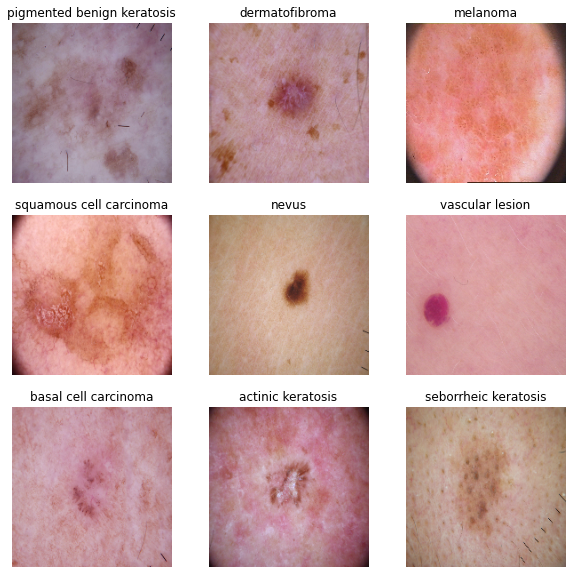

In [29]:
#Below code takes one instance and plots one image per class. IF first instance has only 7 or 8 classes , then it takes another instance and plots the images.
#It tries till the instance took has atleast one image from all 9 classes

all_plotted = False
plt.figure(figsize=(10, 10))
while not(all_plotted):
  count = 0
  plotted_class = []
  for images, labels in train_ds.take(1):
    for i in range(batch_size):
      if labels[i] not in plotted_class:
       ax = plt.subplot(3, 3, count + 1)
       plt.imshow(images[i].numpy().astype("uint8"))
       plt.title(class_names[labels[i]])
       plotted_class.append(labels[i])
       count+= 1
       if count == 9:
         all_plotted = True
       plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [31]:
### Your code goes here
num_classes = 9

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [32]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 178, 178, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 87, 87, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0

### Train the model

In [34]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 48s 125ms/step - loss: 2.2807 - accuracy: 0.1967 - val_loss: 1.9021 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.7784 - accuracy: 0.3463 - val_loss: 1.6796 - val_accuracy: 0.4899
Epoch 3/20
56/56 [==============================] - 3s 53ms/step - loss: 1.6118 - accuracy: 0.4491 - val_loss: 1.6443 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 3s 54ms/step - loss: 1.5142 - accuracy: 0.4810 - val_loss: 1.5348 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4329 - accuracy: 0.5151 - val_loss: 1.4324 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4154 - accuracy: 0.4996 - val_loss: 1.4108 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4903 - accuracy: 0.4848 - val_loss: 1.5265 - val_accuracy: 0.4787
Epoch 8/20


### Visualizing training results

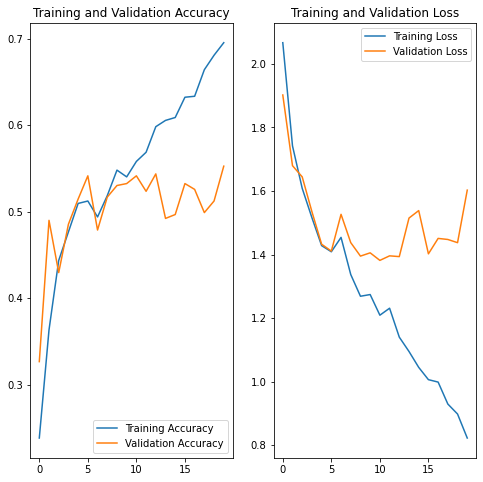

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

# Findings from above model
* Looking at the model metrics train accuracy of ~70 and validation accuracy of ~55 gives us an indication of **Model Overfitting**. 
* Looking at the abve visualization shows that training is decreasing wheresas validation became stable around 1.4 to 1.5
* We can do much better with both training and validation accuracies
* Below cell shows the data augmentation strategy using Keras ImageDataGenerator API

In [36]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

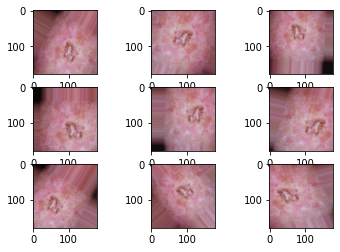

In [37]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

# Your code goes here
for images,labels in train_ds.take(1):
  img = images[1]
  x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

  it = datagen.flow(x,batch_size=1)
# generate samples and plot
  for i in range(9):
	  # define subplot
	  plt.subplot(330 + 1 + i)
	  # generate batch of images
	  batch = it.next()
  	# convert to unsigned integers for viewing
	  image = batch[0].astype('uint8')
	  # plot raw pixel data
	  plt.imshow(image)
    # show the figure
  plt.show()


### Todo:
### Create the model, compile and train the model


In [38]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



### Compiling the model

In [39]:
## Your code goes here
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [40]:
## Your code goes here, note: train your model for 20 epochs

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        data_dir_train,
        class_mode = 'sparse',
        target_size=(img_height,img_width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
        data_dir_test,
        class_mode = 'sparse',
        target_size=(img_height,img_width),
        batch_size=batch_size)

epochs = 20

#y_train = tf.keras.utils.to_categorical(y_train, num_classes)

history = model.fit(
  train_generator,
  steps_per_epoch=math.ceil(train_generator.samples//batch_size),
  validation_data=validation_generator,
  validation_steps = math.ceil(validation_generator.samples//batch_size),
  epochs = epochs
)## your training code

model.save_weights('first_try.h5')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Epoch 1/20
69/69 [==============================] - 62s 892ms/step - loss: 2.5711 - accuracy: 0.2124 - val_loss: 2.1799 - val_accuracy: 0.1771
Epoch 2/20
69/69 [==============================] - 60s 865ms/step - loss: 1.8782 - accuracy: 0.3036 - val_loss: 2.1958 - val_accuracy: 0.2812
Epoch 3/20
69/69 [==============================] - 59s 856ms/step - loss: 1.7426 - accuracy: 0.3626 - val_loss: 2.3446 - val_accuracy: 0.1875
Epoch 4/20
69/69 [==============================] - 59s 855ms/step - loss: 1.7244 - accuracy: 0.3659 - val_loss: 2.1009 - val_accuracy: 0.3333
Epoch 5/20
69/69 [==============================] - 58s 849ms/step - loss: 1.5440 - accuracy: 0.4678 - val_loss: 2.2563 - val_accuracy: 0.3021
Epoch 6/20
69/69 [==============================] - 59s 857ms/step - loss: 1.6118 - accuracy: 0.4188 - val_loss: 2.2138 - val_accuracy: 0.2917
Epoch 7/20
69/69 [==============================] - 58s 841

### Visualizing the results

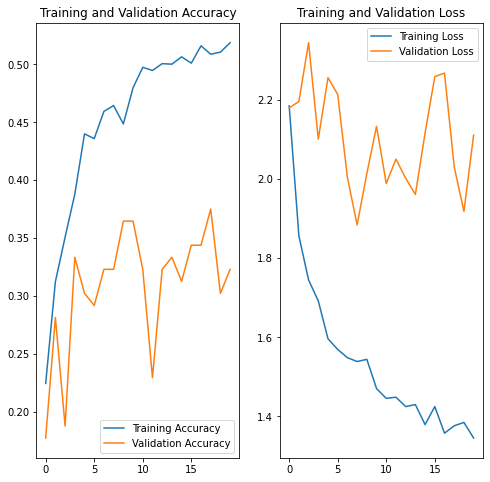

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


* Comparing with model with original data, model with augmented data performed bad.
* Model with original data : training accuracy - 70, validation accuracy - 55
* Model with augmented data : training accuracy - 53, validation accuracy - 32
* Model with augmented clearly shows **Under-fitting**
* It is clear that *Data Augmentation* did not solve our over fitting problem, instead it made the model underfit

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
Name: ClassId, dtype: float64


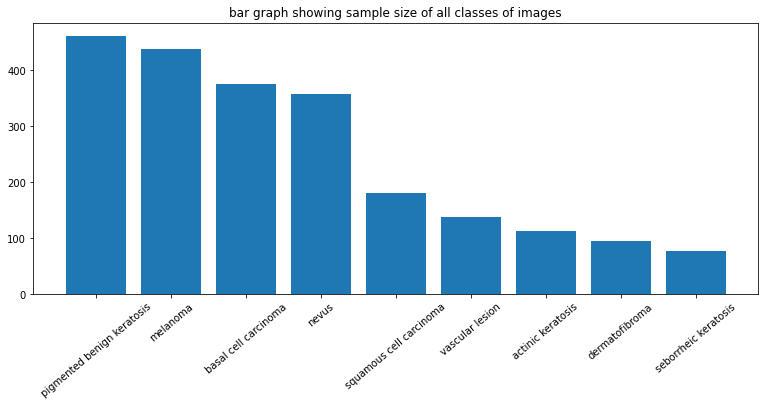

In [53]:
## Your code goes here.
path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

train_image_names = pd.Series(original_df['Path'])
train_df = pd.DataFrame()
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])
train_df['ClassId'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])
class_id_distribution = train_df['ClassId'].value_counts()
print(train_df['ClassId'].value_counts(normalize=True))
plt.figure(figsize=(13,5))
plt.title('bar graph showing sample size of all classes of images')
plt.xticks(rotation = 40)
plt.bar(class_id_distribution.index, class_id_distribution.values)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
* *Seborrheic keratosis* class has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
* *pigmented benign keratosis* is the dominating class in terms of proportion

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [54]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [55]:
path_to_training_dataset='Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F829954F790>: 100%|██████████| 500/500 [00:18<00:00, 27.49 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F822DA5F0D0>:   0%|          | 1/500 [00:00<00:55,  8.97 Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F822D9D5910>: 100%|██████████| 500/500 [00:17<00:00, 27.90 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82E31BC890>: 100%|██████████| 500/500 [00:18<00:00, 27.06 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F822D90A050>: 100%|██████████| 500/500 [01:42<00:00,  4.89 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F822DA49750>:   0%|          | 1/500 [00:00<01:34,  5.28 Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=959x634 at 0x7F822D9D5910>: 100%|██████████| 500/500 [01:12<00:00,  6.92 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F829940E350>:   0%|          | 1/500 [00:00<00:53,  9.24 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F822E08DE10>: 100%|██████████| 500/500 [00:18<00:00, 27.00 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F82E604AA50>:   0%|          | 1/500 [00:00<01:32,  5.42 Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F82E5FB6E50>: 100%|██████████| 500/500 [00:41<00:00, 11.91 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F822DDFCA90>: 100%|██████████| 500/500 [00:17<00:00, 27.90 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F822DC2A990>: 100%|██████████| 500/500 [00:17<00:00, 28.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [56]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [57]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025005.jpg_4afdea46-e3f8-4d3c-bd51-525ffa2b6f37.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025209.jpg_9203d524-5171-4afb-a656-389655a65695.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024910.jpg_0fd7ff7a-03a6-4468-b4fe-8bc26390c393.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027354.jpg_ac12ad16-3df8-4cb0-9f07-2766faf42633.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025642.jpg_82d088cd-1c4d-4624-8eb8-e466411fa91a.jpg',


In [58]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [59]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [60]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [61]:
new_df['Label'].value_counts()

Train                         2239
basal cell carcinoma           500
squamous cell carcinoma        500
actinic keratosis              500
dermatofibroma                 500
vascular lesion                500
pigmented benign keratosis     500
nevus                          500
seborrheic keratosis           500
melanoma                       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [62]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [63]:
data_dir_train= pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [64]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [65]:
## your code goes here
num_classes = 9

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [66]:
## your code goes here
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [67]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/30
169/169 [==============================] - 47s 268ms/step - loss: 10.0561 - accuracy: 0.2603 - val_loss: 11.0435 - val_accuracy: 0.1002
Epoch 2/30
169/169 [==============================] - 44s 255ms/step - loss: 1.8193 - accuracy: 0.3310 - val_loss: 9.5792 - val_accuracy: 0.1477
Epoch 3/30
169/169 [==============================] - 44s 253ms/step - loss: 1.6577 - accuracy: 0.3778 - val_loss: 5.3727 - val_accuracy: 0.2962
Epoch 4/30
169/169 [==============================] - 45s 260ms/step - loss: 1.6711 - accuracy: 0.3952 - val_loss: 22.4769 - val_accuracy: 0.1745
Epoch 5/30
169/169 [==============================] - 44s 257ms/step - loss: 1.5592 - accuracy: 0.4216 - val_loss: 1.6832 - val_accuracy: 0.3727
Epoch 6/30
169/169 [==============================] - 44s 257ms/step - loss: 1.5303 - accuracy: 0.4059 - val_loss: 3.1727 - val_accuracy: 0.3408
Epoch 7/30
169/169 [==============================] - 44s 255ms/step - loss: 1.4524 - accuracy: 0.4583 - val_loss: 1.6728 - val

#### **Todo:**  Visualize the model results

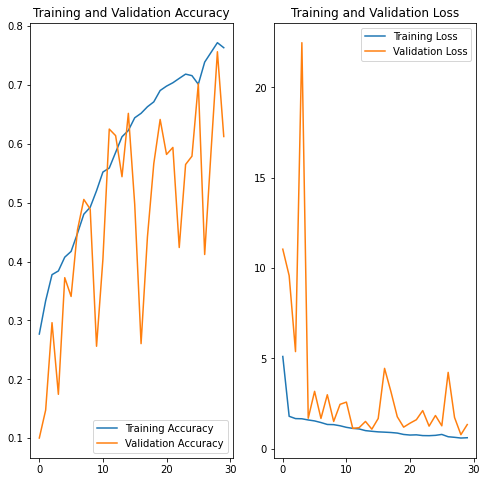

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



* After class rebalancing, we could see improvement in model performance
* Model with original data : training accuracy - 70, validation accuracy - 55
* Model with augmented data : training accuracy - 53, validation accuracy - 32
* Model with Class Rebalanced data : training accuracy - 76, validation accuracy - 61
* But, This cannot be said as a very good performance, we clearly see a lot of difference between training and validation accuracy.
* We could try altering the neural network architecture adding or removing  conv layers, dropouts, normalizations and also trying with optimizers and loss functions
* There is possiblity to improve the model performance by playing with hyper parameters